# Identifying potential location for Chinese Restaurant in Toronto

### _The Battle of Neighborhoods - Applied Data Science Capstone by IBM/Coursera_

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

# Introduction: Business Problem <a name="introduction"></a>


Toronto, the most populous city in Canada attracts both visitors and investors because of its many neighbourhoods with diverse businesses, culture and arts.

This project aims at finding best possible location for a restaurant within the neighbourhoods. This is to particularly assist a businessperson who is interested in opening a Chinese restaurant in Toronto, Ontario. Meanwhile there are a lot of restaurants in Toronto. We will try to identify locations with less or no restaurants, especially neighbourhoods with no Chinese restaurants.

Using data science approaches, we will generate a few most likely neighbourhoods, clearly expressing advantages of each area in order that the businessperson can choose the best possible location.


# Data <a name="data"></a>


Neighbourhoods and boroughs in Toronto will be obtained from the Wikipedia page: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M. To have the Wikipedia page in a structured format for exploring and clustering the neighbourhoods in the city of Toronto, **BeautifulSoup package** (https://beautiful-soup-4.readthedocs.io/en/latest/) will be used to scrape the page, wrangle and clean the data, and read into pandas dataframe. The geographical coordinates of each Toronto’s postal code area will be obtained from csv file link: http://cocl.us/Geospatial_data. 

**Foursquare API** will be used to obtain number of restaurants and their type alongside location in every neighbourhood.

In [1]:
# Install important libraries
!conda install -c conda-forge geopy --yes

!conda install -c conda-forge folium=0.5.0 --yes 

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.21.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

### _Data acquisition, cleaning and exploration_
Using BeautifulSoup package (https://beautiful-soup-4.readthedocs.io/en/latest/), scrape the list of Toronto neighborhoods from the Wikipedia page. 

In [2]:
# Import Libraries

from bs4 import BeautifulSoup
import requests
import urllib.request
import time
import pandas as pd

In [3]:
# Connect to the url and scrape the web page
# Obtain the table text after examining the page

url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
response = requests.get(url)

soup = BeautifulSoup(response.text, 'html.parser')
# Find the table class
My_table = soup.find('table',{'class':'wikitable sortable'})

In [4]:
### Obtain table headers

t_headers = []
for th in My_table.find_all("th"):
    # from left and right, remove any newlines and extra spaces 
    t_headers.append(th.text.replace('\n', ' ').strip())
print(t_headers)

['Postcode', 'Borough', 'Neighbourhood']


In [5]:
# Obtain table data and zip each row to the headers

table_data = []
for tr in My_table.tbody.find_all("tr"): # find all tr's from table's tbody
    t_row = {}
    
    # Each table row is stored in the form of
    # t_row = {'Postcode': '', 'Borough': '', 'Neighbourhood': ''}

    for td, th in zip(tr.find_all("td"), t_headers): 
        t_row[th] = td.text.replace('\n', '').strip()
    table_data.append(t_row)

### _Transform the data into pandas dataframe and clean the data_

Fix inconsistency in the column neighborhood with misspelling in the wikip page

In [6]:
df_data_table = pd.DataFrame(table_data[1:], columns=t_headers)

# drop all rows where Borough column is 'Not assigned'
df_data_table = df_data_table.loc[df_data_table.Borough != 'Not assigned']

# fix the 'Not assinged' issue on the Neighbourhood column
df_data_table.loc[df_data_table.Neighbourhood=='Not assigned', 'Neighbourhood'] = \
df_data_table.loc[df_data_table.Neighbourhood=='Not assigned', 'Borough']

# sort values based on the postcode column
df_data_table = df_data_table.sort_values(by='Postcode')
# rename misspelt column in the wiki page
df_data_table = df_data_table.rename(columns={'Neighbourhood': 'Neighborhood'})

# group the borough and concatenate the neighborhood names with comma
df_data_table = df_data_table.groupby(['Postcode', 'Borough'])['Neighborhood'].apply(','.join)
df_data_table = pd.DataFrame(df_data_table)

# reset the dataframe index
df_data_table.reset_index(inplace=True)

df_data_table.head()

,Postcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Port Union,Rouge Hill,Highland Creek"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [7]:
df_data_table.shape

(103, 3)

### Geocoding

In [8]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

In [9]:
url = "http://cocl.us/Geospatial_data"
df1 = pd.read_csv(url)
df1.rename(columns={'Postal Code': 'Postcode'}, inplace=True) 
df1.head()

,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [10]:
## Alternatively!
df_pcodes = pd.read_csv(url)
df_pcodes = df_pcodes.rename(columns={'Postal Code': 'Postcode'})
df_pcodes.head()

,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [11]:
df2 = pd.merge(df_data_table, df1, on='Postcode')
df2.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Port Union,Rouge Hill,Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [12]:
## Or
df_data_table = df_data_table.merge(df_pcodes[['Latitude', 'Longitude', 'Postcode']], on="Postcode")
df_data_table.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Port Union,Rouge Hill,Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [13]:
print('The dataframe has {} Borough and {} Neighbourhood.'.format(
        len(df2['Borough'].unique()),
        df2.shape[0]
    )
)

The dataframe has 11 Borough and 103 Neighbourhood.


In [14]:
Toronto=df_data_table[df_data_table['Borough'].str.contains('Toronto')]
Toronto

,Postcode,Borough,Neighborhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
41,M4K,East Toronto,"Riverdale,The Danforth West",43.679557,-79.352188
42,M4L,East Toronto,"The Beaches West,India Bazaar",43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
45,M4P,Central Toronto,Davisville North,43.712751,-79.390197
46,M4R,Central Toronto,North Toronto West,43.715383,-79.405678
47,M4S,Central Toronto,Davisville,43.704324,-79.388790
48,M4T,Central Toronto,"Summerhill East,Moore Park",43.689574,-79.383160
49,M4V,Central Toronto,"South Hill,Summerhill West,Rathnelly,Forest Hi...",43.686412,-79.400049


In [15]:
df2.rename(columns={'Neighbourhood': 'Neighborhood'}, inplace=True)

In [16]:
#count Borough and Neighborhood
df2.groupby('Borough').count()['Neighborhood']

Borough
Central Toronto      9
Downtown Toronto    19
East Toronto         5
East York            5
Etobicoke           11
Mississauga          1
North York          24
Queen's Park         1
Scarborough         17
West Toronto         6
York                 5
Name: Neighborhood, dtype: int64

In [17]:
#Create list with the Boroughs (to be used later)
boroughs = Toronto['Borough'].unique().tolist()

In [18]:
#Obtain the coordinates from the dataset itself, just averaging Latitude/Longitude of the current dataset 
lat_toronto = Toronto['Latitude'].mean()
lon_toronto = Toronto['Longitude'].mean()
print('The geographical coordinates of Toronto are {}, {}'.format(lat_toronto, lon_toronto))

The geographical coordinates of Toronto are 43.66713498717948, -79.38987324871795


### _Import more important Libraries_

In [19]:
import folium
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np # library to handle data in a vectorized manner
from sklearn.cluster import KMeans # import k-means from clustering stage
import random 
from sklearn.datasets.samples_generator import make_blobs 
%matplotlib inline

In [20]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.0.2


In [21]:
import seaborn 
import seaborn as sns
from matplotlib import pyplot 
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)

In [22]:
# create a map of toronto
geolocator = Nominatim(user_agent="coursera")
address = 'Toronto'
try:
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print('The geograpical coordinates of {} are {}, {}.'.format(address, latitude, longitude))
except AttributeError:
    print('Cannot find: {}, will drop index: {}'.format(address, index))

toronto_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_data_table['Latitude'], df_data_table['Longitude'], df_data_table['Postcode']):
    label = folium.Popup(label)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(toronto_map)  
    
toronto_map

The geograpical coordinates of Toronto are 43.653963, -79.387207.


### FOURSQUARE 
Use the Foursquare API to explore the neighborhoods and segment them.
Get information on restaurants in each neighborhood.

Interest is in venues in 'food' category,especially proper restaurants. The likes of coffe shops, pizza places, bakeries etc. are less likely in direct competition. While concentrating on venues with 'restaurant' in category name, special attention is on 'Chinese restaurant' category.


Foursquare credentials are defined in hidden cell bellow.

In [23]:
CLIENT_ID = 'L05ZB5YELSAAWSUOOMF1CUWOLO2T1IWPW1QM2TP005FTE0VV' # Foursquare ID
CLIENT_SECRET = 'GB3O3HA3TFSEJR52XDL0WG4XDLSVIWNL3NLJ0T1ZY013EPUO' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: L05ZB5YELSAAWSUOOMF1CUWOLO2T1IWPW1QM2TP005FTE0VV
CLIENT_SECRET:GB3O3HA3TFSEJR52XDL0WG4XDLSVIWNL3NLJ0T1ZY013EPUO


### _Exploring the first neighborhood in the dataframe_

Get the neighborhood's name.

In [24]:
df_data_table.set_index('Postcode', inplace = True) 
neighborhood_latitude = df_data_table.loc['M6G']['Latitude']
neighborhood_longitude = df_data_table.loc['M6G']['Longitude']

In [25]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=L05ZB5YELSAAWSUOOMF1CUWOLO2T1IWPW1QM2TP005FTE0VV&client_secret=GB3O3HA3TFSEJR52XDL0WG4XDLSVIWNL3NLJ0T1ZY013EPUO&v=20180605&ll=43.669542,-79.4225637&radius=500&limit=100'

In [26]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e3d3769b9a389001b378b82'},
 'response': {'headerLocation': 'Christie Pits',
  'headerFullLocation': 'Christie Pits, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 18,
  'suggestedBounds': {'ne': {'lat': 43.6740420045, 'lng': -79.41635411972038},
   'sw': {'lat': 43.6650419955, 'lng': -79.42877328027961}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4adcfd7cf964a5203e6321e3',
       'name': 'Fiesta Farms',
       'location': {'address': '200 Christie St',
        'crossStreet': 'at Essex St',
        'lat': 43.66847077052224,
        'lng': -79.42048512748114,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.66847077052224,
          'lng': -79.42048512748114}],
        'distance': 20

In [27]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [28]:
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues) 
nearby_venues

,reasons.count,reasons.items,referralId,venue.categories,venue.id,venue.location.address,venue.location.cc,venue.location.city,venue.location.country,venue.location.crossStreet,...,venue.location.formattedAddress,venue.location.labeledLatLngs,venue.location.lat,venue.location.lng,venue.location.postalCode,venue.location.state,venue.name,venue.photos.count,venue.photos.groups,venue.venuePage.id
0,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4adcfd7cf964a5203e6321e3-0,"[{'id': '4bf58dd8d48988d118951735', 'name': 'G...",4adcfd7cf964a5203e6321e3,200 Christie St,CA,Toronto,Canada,at Essex St,...,"[200 Christie St (at Essex St), Toronto ON M6G...","[{'label': 'display', 'lat': 43.66847077052224...",43.668471,-79.420485,M6G 3B6,ON,Fiesta Farms,0,[],56848730
1,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-540c8301498e51456f71ae7e-1,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",540c8301498e51456f71ae7e,1028 Shaw St,CA,Toronto,Canada,Yarmouth,...,"[1028 Shaw St (Yarmouth), Toronto ON, Canada]","[{'label': 'display', 'lat': 43.66910714407297...",43.669107,-79.426105,NaN,ON,Contra Cafe,0,[],NaN
2,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4dc9d2add4c07b350108956a-2,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",4dc9d2add4c07b350108956a,657 Dupont St,CA,Toronto,Canada,at Christie St.,...,"[657 Dupont St (at Christie St.), Toronto ON M...","[{'label': 'display', 'lat': 43.67153, 'lng': ...",43.671530,-79.421400,M6G 1Z4,ON,Starbucks,0,[],NaN
3,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4b003cf6f964a520d73b22e3-3,"[{'id': '4bf58dd8d48988d110941735', 'name': 'I...",4b003cf6f964a520d73b22e3,787 Dupont Street,CA,Toronto,Canada,NaN,...,"[787 Dupont Street, Toronto ON M6G 1Z5, Canada]","[{'label': 'display', 'lat': 43.67067884412717...",43.670679,-79.426148,M6G 1Z5,ON,Vinny’s Panini,0,[],NaN
4,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4adb4d20f964a520b12521e3-4,"[{'id': '4bf58dd8d48988d147941735', 'name': 'D...",4adb4d20f964a520b12521e3,1071 Shaw St.,CA,Toronto,Canada,Dupont,...,"[1071 Shaw St. (Dupont), Toronto ON, Canada]","[{'label': 'display', 'lat': 43.67054982071192...",43.670550,-79.426541,NaN,ON,Universal Grill,0,[],NaN
5,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-536e42af498e8a0880b220d7-5,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",536e42af498e8a0880b220d7,146 Christie Street,CA,Toronto,Canada,Bloor,...,"[146 Christie Street (Bloor), Toronto ON M6G 3...","[{'label': 'display', 'lat': 43.66735987720157...",43.667360,-79.419938,M6G 3B3,ON,Scout and Cash Caffe,0,[],85621950
6,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4ade0037f964a520396721e3-6,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",4ade0037f964a520396721e3,672 Dupont Street,CA,Toronto,Canada,Christie,...,"[672 Dupont Street (Christie), Toronto ON M6G ...","[{'label': 'display', 'lat': 43.6710456734398,...",43.671046,-79.419297,M6G 1Z6,ON,Faema Caffe,0,[],NaN
7,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4f737b84e4b060af1b23c5b7-7,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",4f737b84e4b060af1b23c5b7,971 Ossington Ave,CA,Toronto,Canada,NaN,...,"[971 Ossington Ave, Toronto ON M6G 3V5, Canada]","[{'label': 'display', 'lat': 43.66785822046965...",43.667858,-79.428054,M6G 3V5,ON,Actinolite,0,[],NaN
8,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4b76e890f964a52065692ee3-8,"[{'id': '4bf58dd8d48988d117951735', 'name': 'C...",4b76e890f964a52065692ee3,653 Dupont Street,CA,Toronto,Canada,"""at Christie St.""",...,"[653 Dupont Street (""at Christie St.""), Toront...","[{'label': 'display', 'lat': 43.67156577026589...",43.671566,-79.421289,M6G 1Z4,ON,Stubbe Chocolates,0,[],NaN
9,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4aee0faef964a520b1d121e3-9,"[{'id': '4bf58dd8d48988d118951735', 'name': 'G...",4aee0faef964a520b1d121e3,650 Dupont St,CA,Toronto,Canada,at Christie St.,...,"[650 Dupont St (at Christie St.), Toronto ON M..."

In [29]:
# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Fiesta Farms,Grocery Store,43.668471,-79.420485
1,Contra Cafe,Café,43.669107,-79.426105
2,Starbucks,Coffee Shop,43.671530,-79.421400
3,Vinny’s Panini,Italian Restaurant,43.670679,-79.426148
4,Universal Grill,Diner,43.670550,-79.426541


### _Venues returned_

In [30]:
print(f'{nearby_venues.shape[0]} venues were returned by Foursquare.')

18 venues were returned by Foursquare.


In [31]:
nearby_venues.shape

(18, 4)

### _Venues in 500 m' radius_


In [32]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [33]:
venues = getNearbyVenues(names=df_data_table['Borough'],latitudes=df_data_table['Latitude'],longitudes=df_data_table['Longitude'])

Scarborough
Scarborough
Scarborough
Scarborough
Scarborough
Scarborough
Scarborough
Scarborough
Scarborough
Scarborough
Scarborough
Scarborough
Scarborough
Scarborough
Scarborough
Scarborough
Scarborough
North York
North York
North York
North York
North York
North York
North York
North York
North York
North York
North York
North York
North York
North York
North York
North York
North York
North York
East York
East York
East Toronto
East York
East York
East York
East Toronto
East Toronto
East Toronto
Central Toronto
Central Toronto
Central Toronto
Central Toronto
Central Toronto
Central Toronto
Downtown Toronto
Downtown Toronto
Downtown Toronto
Downtown Toronto
Downtown Toronto
Downtown Toronto
Downtown Toronto
Downtown Toronto
Downtown Toronto
Downtown Toronto
Downtown Toronto
Downtown Toronto
North York
Central Toronto
Central Toronto
Central Toronto
Downtown Toronto
Downtown Toronto
Downtown Toronto
Downtown Toronto
Downtown Toronto
North York
North York
York
York
Downtown Toronto
Wes

In [34]:
# check output
print(venues.shape)
venues.head()

(2213, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Scarborough,43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,Scarborough,43.806686,-79.194353,Interprovincial Group,43.805630,-79.200378,Print Shop
2,Scarborough,43.784535,-79.160497,Chris Effects Painting,43.784343,-79.163742,Construction & Landscaping
3,Scarborough,43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
4,Scarborough,43.784535,-79.160497,Affordable Toronto Movers,43.787919,-79.162977,Moving Target


In [35]:
venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Central Toronto,115,115,115,115,115,115
Downtown Toronto,1296,1296,1296,1296,1296,1296
East Toronto,122,122,122,122,122,122
East York,77,77,77,77,77,77
Etobicoke,74,74,74,74,74,74
Mississauga,12,12,12,12,12,12
North York,242,242,242,242,242,242
Scarborough,84,84,84,84,84,84
West Toronto,173,173,173,173,173,173


# Methodology <a name="methodology"></a>

This project is about detecting areas (neighborhoods)  with low density of Chinese restaurants within neighborhoods in the city of Toronto. Required data was collected through the scraping of Wikipedia page using BeautifulSoup package, read into Pandas dataframe. Geopy.geocoders was used to convert addresses in each Toronto’s postal code area into geographical coordinates. Foursquare API was used to explore and segment the neighborhoods, and  extract information on venues and category of each venue in each neighborhood. 

Having identified boroughs with Chinese restaurants through UNIQUE-VENUE-CATEGORIZATION, analysis and exploration of 'Chinese restaurant density' across boroughs (neighborhoods) in Toronto was performed. Both bar grapghs and scatter plots (violin plot) were used to visualise the density of Chinese restaurants in each borough.

K-means clustering was used to group the neighborhoods into 5, and visualised on map using folium.  Counts of unique venues (including Chinese restaurant) were produced by means of bar graphs.


# Analysis <a name="analysis"></a>

### _Analyse the Neighborhoods_

In [36]:
# Using one hot encoding
onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# read neighborhood column to dataframe
onehot['Neighborhood'] = venues['Neighborhood'] 

onehot.head()

,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
grouped = onehot.groupby('Neighborhood').mean().reset_index()
grouped

,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Central Toronto,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017391,...,0.000000,0.008696,0.000000,0.000000,0.008696,0.000000,0.000000,0.000000,0.000000,0.008696
1,Downtown Toronto,0.000000,0.000772,0.000772,0.000772,0.000772,0.001543,0.002315,0.001543,0.013117,...,0.002315,0.011574,0.001543,0.000000,0.004630,0.000000,0.006944,0.000000,0.000772,0.003858
2,East Toronto,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024590,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008197,0.000000,0.000000,0.016393
3,East York,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.012987,0.000000,0.012987,0.000000,0.000000,0.000000,0.012987
4,Etobicoke,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013514,0.000000,0.000000
5,Mississauga,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,North York,0.004132,0.000000,0.004132,0.000000,0.000000,0.000000,0.000000,0.000000,0.008264,...,0.000000,0.000000,0.004132,0.004132,0.008264,0.000000,0.000000,0.004132,0.008264,0.000000
7,Scarborough,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011905,...,0.000000,0.000000,0.000000,0.000000,0.011905,0.000000,0.000000,0.000000,0.000000,0.000000
8,West Toronto,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.011561,0.000000,0.000000,0.011561,0.000000,0.005780,0.000000,0.000000,0.017341
9,York,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000


In [38]:
uniques = venues['Venue Category'].unique()

In [39]:
uniques

array(['Fast Food Restaurant', 'Print Shop', 'Construction & Landscaping',
       'Bar', 'Moving Target', 'Pizza Place', 'Electronics Store',
       'Mexican Restaurant', 'Rental Car Location', 'Medical Center',
       'Intersection', 'Breakfast Spot', 'Coffee Shop',
       'Korean Restaurant', 'Hakka Restaurant', 'Caribbean Restaurant',
       'Athletics & Sports', 'Thai Restaurant', 'Bank', 'Gas Station',
       'Bakery', 'Fried Chicken Joint', 'Playground', 'Department Store',
       'Chinese Restaurant', 'Hobby Shop', 'Ice Cream Shop', 'Bus Line',
       'Bus Station', 'Park', 'Soccer Field', 'Motel',
       'American Restaurant', 'Café', 'General Entertainment',
       'Skating Rink', 'College Stadium', 'Indian Restaurant',
       'Pet Store', 'Vietnamese Restaurant', 'Smoke Shop',
       'Middle Eastern Restaurant', 'Lounge', 'Latin American Restaurant',
       'Clothing Store', 'Italian Restaurant', 'Noodle House',
       'Shopping Mall', 'Convenience Store', 'Pharmacy', 'Sandwi

In [40]:
import re
uniqueList = uniques.tolist()

len(uniqueList)

265

### _Explore  venues for targeting food places and hangout places_

In [41]:
targets = ['Restaurant', 'Joint', 'Place', 'Theater', 'Music', 'Club', 'club', 'Cocktail', 'cocktail', 'Roof', \
           'Café', 'Lounge', 'Pub', 'pub', 'House','Cafe','Wine','Food'\
          'Nightlife', 'Party']

matching = [s for s in uniqueList if any(xs in s for xs in targets)]
len(matching)

78

In [42]:
mask = venues['Venue Category'].isin(matching)
Places_food = venues[mask]
Places_food.reset_index(inplace = True)
Places_food.drop('index', axis = 1, inplace = True)
Places_food.shape

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(905, 7)

In [43]:
Places_food.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Scarborough,43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,Scarborough,43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
2,Scarborough,43.763573,-79.188711,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant
3,Scarborough,43.770992,-79.216917,Korean Grill House,43.770812,-79.214502,Korean Restaurant
4,Scarborough,43.773136,-79.239476,Federick Restaurant,43.774697,-79.241142,Hakka Restaurant


In [44]:
hangout_places = ['Restaurant','joints','Place','Joint','Cafe','cafe','Café','Theater','House']
matching = [s for s in uniqueList if any(xs in s for xs in hangout_places)]
mealMask = Places_food['Venue Category'].isin(matching)
nightMask = ~mealMask
eats = Places_food[mealMask]
Places_ho = Places_food[nightMask]
Places_ho.reset_index(inplace = True)
Places_ho.shape

(102, 8)

In [45]:
Places_ho.head()

,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,16,Scarborough,43.794200,-79.262029,Twilight,43.791999,-79.258584,Lounge
1,63,North York,43.770120,-79.408493,Aura,43.766013,-79.410813,Lounge
2,100,East York,43.706397,-79.309937,Jawny Bakers,43.705783,-79.312913,Gastropub
3,107,East Toronto,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
4,127,East Toronto,43.679557,-79.352188,The Auld Spot Pub,43.677335,-79.353130,Pub


In [46]:
num_top_venues = 5

for hood in grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = grouped[grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Central Toronto----
            venue  freq
0     Coffee Shop  0.07
1  Sandwich Place  0.06
2            Park  0.05
3            Café  0.05
4             Gym  0.03


----Downtown Toronto----
         venue  freq
0  Coffee Shop  0.11
1         Café  0.05
2        Hotel  0.03
3   Restaurant  0.03
4          Bar  0.02


----East Toronto----
                venue  freq
0    Greek Restaurant  0.08
1         Coffee Shop  0.06
2  Italian Restaurant  0.05
3             Brewery  0.04
4                Park  0.03


----East York----
                  venue  freq
0           Coffee Shop  0.06
1  Fast Food Restaurant  0.04
2   Sporting Goods Shop  0.04
3          Burger Joint  0.04
4                  Bank  0.04


----Etobicoke----
            venue  freq
0     Pizza Place  0.09
1  Sandwich Place  0.07
2     Coffee Shop  0.05
3    Liquor Store  0.04
4        Pharmacy  0.04


----Mississauga----
                 venue  freq
0                Hotel  0.17
1          Coffee Shop  0.17
2        Burrit

In [47]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [48]:
Places_food_counts = Places_food.groupby(['Neighborhood'], as_index = False).count()

In [49]:
Places_food_counts.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Central Toronto,48,48,48,48,48,48
1,Downtown Toronto,548,548,548,548,548,548
2,East Toronto,49,49,49,49,49,49
3,East York,21,21,21,21,21,21
4,Etobicoke,28,28,28,28,28,28


In [50]:
# check if the results contain "Chinese Restaurants"
"Chinese Restaurant" in venues['Venue Category'].unique()

True

In [51]:
# one hot encoding
to_onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
to_onehot['Neighborhoods'] = venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

print(to_onehot.shape)
to_onehot.head()

(2213, 266)


,Neighborhoods,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Scarborough,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Scarborough,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Scarborough,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Scarborough,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Scarborough,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [52]:
to_grouped = to_onehot.groupby(["Neighborhoods"]).mean().reset_index()

print(to_grouped.shape)
to_grouped

(10, 266)


,Neighborhoods,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Central Toronto,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017391,...,0.000000,0.008696,0.000000,0.000000,0.008696,0.000000,0.000000,0.000000,0.000000,0.008696
1,Downtown Toronto,0.000000,0.000772,0.000772,0.000772,0.000772,0.001543,0.002315,0.001543,0.013117,...,0.002315,0.011574,0.001543,0.000000,0.004630,0.000000,0.006944,0.000000,0.000772,0.003858
2,East Toronto,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024590,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008197,0.000000,0.000000,0.016393
3,East York,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.012987,0.000000,0.012987,0.000000,0.000000,0.000000,0.012987
4,Etobicoke,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013514,0.000000,0.000000
5,Mississauga,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,North York,0.004132,0.000000,0.004132,0.000000,0.000000,0.000000,0.000000,0.000000,0.008264,...,0.000000,0.000000,0.004132,0.004132,0.008264,0.000000,0.000000,0.004132,0.008264,0.000000
7,Scarborough,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011905,...,0.000000,0.000000,0.000000,0.000000,0.011905,0.000000,0.000000,0.000000,0.000000,0.000000
8,West Toronto,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.011561,0.000000,0.000000,0.011561,0.000000,0.005780,0.000000,0.000000,0.017341
9,York,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000


In [53]:
len(to_grouped[to_grouped["Chinese Restaurant"] > 0])

5

### _Create a new dataframe to find Chinese Restaurants only_

In [54]:
to_chinese = to_grouped[["Neighborhoods","Chinese Restaurant"]]

In [55]:
to_chinese.head()

,Neighborhoods,Chinese Restaurant
0,Central Toronto,0.008696
1,Downtown Toronto,0.009259
2,East Toronto,0.000000
3,East York,0.000000
4,Etobicoke,0.013514


In [56]:
to_chinese

,Neighborhoods,Chinese Restaurant
0,Central Toronto,0.008696
1,Downtown Toronto,0.009259
2,East Toronto,0.000000
3,East York,0.000000
4,Etobicoke,0.013514
5,Mississauga,0.000000
6,North York,0.016529
7,Scarborough,0.059524
8,West Toronto,0.000000
9,York,0.000000


### _Create a table ranking top 10 venues in each Neighborhood (Borough)_

In [57]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = grouped['Neighborhood']

for ind in np.arange(grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Central Toronto,Coffee Shop,Sandwich Place,Park,Café,Restaurant,Pizza Place,Sushi Restaurant,Dessert Shop,Clothing Store,Pub
1,Downtown Toronto,Coffee Shop,Café,Restaurant,Hotel,Bakery,Italian Restaurant,Japanese Restaurant,Bar,Seafood Restaurant,Park
2,East Toronto,Greek Restaurant,Coffee Shop,Italian Restaurant,Brewery,Café,Ice Cream Shop,Park,Pub,Restaurant,Bakery
3,East York,Coffee Shop,Pizza Place,Pharmacy,Bank,Park,Burger Joint,Sporting Goods Shop,Fast Food Restaurant,Gym,Sandwich Place
4,Etobicoke,Pizza Place,Sandwich Place,Coffee Shop,Gym,Fast Food Restaurant,Grocery Store,Pharmacy,Liquor Store,Fried Chicken Joint,Park
5,Mississauga,Hotel,Coffee Shop,American Restaurant,Sandwich Place,Mediterranean Restaurant,Burrito Place,Intersection,Middle Eastern Restaurant,Fried Chicken Joint,Gym
6,North York,Coffee Shop,Clothing Store,Fast Food Restaurant,Pizza Place,Japanese Restaurant,Sandwich Place,Park,Café,Restaurant,Shopping Mall
7,Scarborough,Chinese Restaurant,Breakfast Spot,Bakery,Fast Food Restaurant,Coffee Shop,Pizza Place,Thai Restaurant,Bank,Fried Chicken Joint,Pharmacy
8,West Toronto,Bar,Café,Coffee Shop,Restaurant,Italian Restaurant,Pizza Place,Breakfast Spot,Bakery,Yoga Studio,Gift Shop
9,York,Park,Hockey Arena,Convenience Store,Pizza Place,Caribbean Restaurant,Restaurant,Market,Sandwich Place,Brewery,Fast Food Restaurant


### _CLUSTER THE NEIGHBORHODS IN THE CITY OF TORONTO_

In [58]:
# set number of clusters
toclusters = 3

to_clustering = to_chinese.drop(["Neighborhoods"], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=toclusters, random_state=0).fit(to_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 2, 0, 0, 2, 0, 2, 1, 0, 0], dtype=int32)

In [59]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
to_merged = to_chinese.copy()

# add clustering labels
to_merged["Cluster Labels"] = kmeans.labels_

In [60]:
to_merged.rename(columns={"Neighborhoods": "Neighborhood"}, inplace=True)
to_merged.head()

,Neighborhood,Chinese Restaurant,Cluster Labels
0,Central Toronto,0.008696,2
1,Downtown Toronto,0.009259,2
2,East Toronto,0.000000,0
3,East York,0.000000,0
4,Etobicoke,0.013514,2


In [61]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
to_merged = to_merged.join(venues.set_index("Neighborhood"), on="Neighborhood")

print(to_merged.shape)
to_merged.head()

(2213, 9)


,Neighborhood,Chinese Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Central Toronto,0.008696,2,43.728020,-79.388790,Lawrence Park Ravine,43.726963,-79.394382,Park
0,Central Toronto,0.008696,2,43.728020,-79.388790,Lake,43.727910,-79.386857,Lake
0,Central Toronto,0.008696,2,43.728020,-79.388790,Zodiac Swim School,43.728532,-79.382860,Swim School
0,Central Toronto,0.008696,2,43.728020,-79.388790,TTC Bus #162 - Lawrence-Donway,43.728026,-79.382805,Bus Line
0,Central Toronto,0.008696,2,43.712751,-79.390197,Sherwood Park,43.716551,-79.387776,Park


In [62]:
# sort the results by Cluster Labels
print(to_merged.shape)
to_merged.sort_values(["Cluster Labels"], inplace=True)
to_merged

(2213, 9)


,Neighborhood,Chinese Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
9,York,0.000000,0,43.706876,-79.518188,Wallace C. Swanek Park,43.708896,-79.522648,Park
3,East York,0.000000,0,43.706397,-79.309937,TKTO - Toronto Knife Throwing Organization,43.709966,-79.313411,Athletics & Sports
3,East York,0.000000,0,43.695344,-79.318389,East York Memorial Arena,43.697224,-79.315397,Skating Rink
3,East York,0.000000,0,43.695344,-79.318389,East York Curling Club,43.696827,-79.313658,Curling Ice
3,East York,0.000000,0,43.695344,-79.318389,The Beer Store,43.693731,-79.316759,Beer Store
3,East York,0.000000,0,43.695344,-79.318389,Shoppers Drug Mart,43.699244,-79.318939,Pharmacy
3,East York,0.000000,0,43.695344,-79.318389,Dance Kids Canada,43.696563,-79.317385,Dance Studio
3,East York,0.000000,0,43.695344,-79.318389,Stan Wadlow Park,43.697836,-79.314303,Park
3,East York,0.000000,0,43.695344,-79.318389,Thai Wok,43.692789,-79.315951,Asian Restaurant
3,East York,0.000000,0,43.695344,-79.318389,New Star Video,43.692565,-79.315937,Video Store


In [63]:
# set number of clusters
kclusters = 5

grouped_clustering = grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 2, 2, 3, 3, 0, 3, 4, 2, 1], dtype=int32)

In [64]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

merged = df_data_table

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
merged = merged.merge(neighborhoods_venues_sorted.set_index('Neighborhood'), left_on='Borough',right_on='Neighborhood')

merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,"Rouge,Malvern",43.806686,-79.194353,4,Chinese Restaurant,Breakfast Spot,Bakery,Fast Food Restaurant,Coffee Shop,Pizza Place,Thai Restaurant,Bank,Fried Chicken Joint,Pharmacy
1,Scarborough,"Port Union,Rouge Hill,Highland Creek",43.784535,-79.160497,4,Chinese Restaurant,Breakfast Spot,Bakery,Fast Food Restaurant,Coffee Shop,Pizza Place,Thai Restaurant,Bank,Fried Chicken Joint,Pharmacy
2,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,4,Chinese Restaurant,Breakfast Spot,Bakery,Fast Food Restaurant,Coffee Shop,Pizza Place,Thai Restaurant,Bank,Fried Chicken Joint,Pharmacy
3,Scarborough,Woburn,43.770992,-79.216917,4,Chinese Restaurant,Breakfast Spot,Bakery,Fast Food Restaurant,Coffee Shop,Pizza Place,Thai Restaurant,Bank,Fried Chicken Joint,Pharmacy
4,Scarborough,Cedarbrae,43.773136,-79.239476,4,Chinese Restaurant,Breakfast Spot,Bakery,Fast Food Restaurant,Coffee Shop,Pizza Place,Thai Restaurant,Bank,Fried Chicken Joint,Pharmacy


### _Map clusters_

In [65]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged['Latitude'], merged['Longitude'], merged['Neighborhood'], merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### _Examine each cluster_

In [68]:
def total_venue_categories(df):
    df_all_venues = df['1st Most Common Venue']
    df_all_venues = df_all_venues.append(df['2nd Most Common Venue'])
    df_all_venues = df_all_venues.append(df['3rd Most Common Venue'])
    df_all_venues = df_all_venues.append(df['4th Most Common Venue'])
    df_all_venues = df_all_venues.append(df['5th Most Common Venue'])
    df_all_venues = df_all_venues.append(df['6th Most Common Venue'])
    df_all_venues = df_all_venues.append(df['7th Most Common Venue'])
    df_all_venues = df_all_venues.append(df['8th Most Common Venue'])
    df_all_venues = df_all_venues.append(df['9th Most Common Venue'])
    df_all_venues = df_all_venues.append(df['10th Most Common Venue'])
    df_cnt = df_all_venues.value_counts().to_frame().reset_index()
    df_cnt.columns = ['Venue Category', 'Venue Count']
    df_cnt.sort_values(by = 'Venue Count', ascending = False)
#return the top 10 venue categories
    return df_cnt.head(10)

## First cluster - Cluster 0


In [66]:
merged.loc[merged['Cluster Labels'] == 0, merged.columns[[1] + list(range(5, merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
90,Canada Post Gateway Processing Centre,Hotel,Coffee Shop,American Restaurant,Sandwich Place,Mediterranean Restaurant,Burrito Place,Intersection,Middle Eastern Restaurant,Fried Chicken Joint,Gym


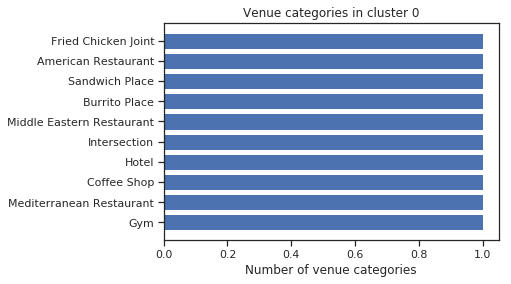

In [69]:
#count venue categories in all neighborhoods in the cluster
t0 = total_venue_categories(merged[merged['Cluster Labels'] == 0])

y_pos = np.arange(len(t0['Venue Category']))
plt.barh(y_pos, t0['Venue Count'], align='center')
plt.yticks(y_pos, t0['Venue Category'])
plt.xlabel('Number of venue categories')
plt.title('Venue categories in cluster 0')
 
plt.show()

## Second cluster - Cluster 1

In [70]:
merged.loc[merged['Cluster Labels'] == 1, merged.columns[[1] + list(range(5, merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
79,Humewood-Cedarvale,Park,Hockey Arena,Convenience Store,Pizza Place,Caribbean Restaurant,Restaurant,Market,Sandwich Place,Brewery,Fast Food Restaurant
80,Caledonia-Fairbanks,Park,Hockey Arena,Convenience Store,Pizza Place,Caribbean Restaurant,Restaurant,Market,Sandwich Place,Brewery,Fast Food Restaurant
81,"Silverthorn,Mount Dennis,Keelesdale,Del Ray",Park,Hockey Arena,Convenience Store,Pizza Place,Caribbean Restaurant,Restaurant,Market,Sandwich Place,Brewery,Fast Food Restaurant
82,"The Junction North,Runnymede",Park,Hockey Arena,Convenience Store,Pizza Place,Caribbean Restaurant,Restaurant,Market,Sandwich Place,Brewery,Fast Food Restaurant
83,Weston,Park,Hockey Arena,Convenience Store,Pizza Place,Caribbean Restaurant,Restaurant,Market,Sandwich Place,Brewery,Fast Food Restaurant


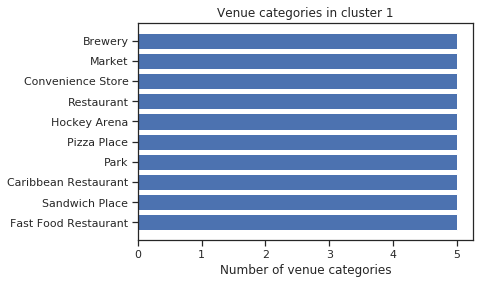

In [71]:
#count venue categories in all neighborhoods in the cluster
t1 = total_venue_categories(merged[merged['Cluster Labels'] == 1])

y_pos = np.arange(len(t1['Venue Category']))
plt.barh(y_pos, t1['Venue Count'], align='center')
plt.yticks(y_pos, t1['Venue Category'])
plt.xlabel('Number of venue categories')
plt.title('Venue categories in cluster 1')
 
plt.show()

## Third cluster - Cluster 2

In [72]:
merged.loc[merged['Cluster Labels'] == 2, merged.columns[[1] + list(range(5, merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
46,The Beaches,Greek Restaurant,Coffee Shop,Italian Restaurant,Brewery,Café,Ice Cream Shop,Park,Pub,Restaurant,Bakery
47,"Riverdale,The Danforth West",Greek Restaurant,Coffee Shop,Italian Restaurant,Brewery,Café,Ice Cream Shop,Park,Pub,Restaurant,Bakery
48,"The Beaches West,India Bazaar",Greek Restaurant,Coffee Shop,Italian Restaurant,Brewery,Café,Ice Cream Shop,Park,Pub,Restaurant,Bakery
49,Studio District,Greek Restaurant,Coffee Shop,Italian Restaurant,Brewery,Café,Ice Cream Shop,Park,Pub,Restaurant,Bakery
50,Business Reply Mail Processing Centre 969 Eastern,Greek Restaurant,Coffee Shop,Italian Restaurant,Brewery,Café,Ice Cream Shop,Park,Pub,Restaurant,Bakery
60,Rosedale,Coffee Shop,Café,Restaurant,Hotel,Bakery,Italian Restaurant,Japanese Restaurant,Bar,Seafood Restaurant,Park
61,"St. James Town,Cabbagetown",Coffee Shop,Café,Restaurant,Hotel,Bakery,Italian Restaurant,Japanese Restaurant,Bar,Seafood Restaurant,Park
62,Church and Wellesley,Coffee Shop,Café,Restaurant,Hotel,Bakery,Italian Restaurant,Japanese Restaurant,Bar,Seafood Restaurant,Park
63,Harbourfront,Coffee Shop,Café,Restaurant,Hotel,Bakery,Italian Restaurant,Japanese Restaurant,Bar,Seafood Restaurant,Park
64,"Garden District,Ryerson",Coffee Shop,Café,Restaurant,Hotel,Bakery,Italian Restaurant,Japanese Restaurant,Bar,Seafood Restaurant,Park


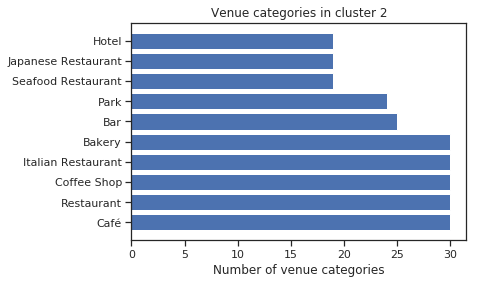

In [73]:
#count venue categories in all neighborhoods in the cluster
t2 = total_venue_categories(merged[merged['Cluster Labels'] == 2])

y_pos = np.arange(len(t2['Venue Category']))
plt.barh(y_pos, t2['Venue Count'], align='center')
plt.yticks(y_pos, t2['Venue Category'])
plt.xlabel('Number of venue categories')
plt.title('Venue categories in cluster 2')
 
plt.show()

## Fourth cluster - Cluster 3


In [74]:
merged.loc[merged['Cluster Labels'] == 3, merged.columns[[1] + list(range(5, merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,Hillcrest Village,Coffee Shop,Clothing Store,Fast Food Restaurant,Pizza Place,Japanese Restaurant,Sandwich Place,Park,Café,Restaurant,Shopping Mall
18,"Henry Farm,Fairview,Oriole",Coffee Shop,Clothing Store,Fast Food Restaurant,Pizza Place,Japanese Restaurant,Sandwich Place,Park,Café,Restaurant,Shopping Mall
19,Bayview Village,Coffee Shop,Clothing Store,Fast Food Restaurant,Pizza Place,Japanese Restaurant,Sandwich Place,Park,Café,Restaurant,Shopping Mall
20,"Silver Hills,York Mills",Coffee Shop,Clothing Store,Fast Food Restaurant,Pizza Place,Japanese Restaurant,Sandwich Place,Park,Café,Restaurant,Shopping Mall
21,"Willowdale,Newtonbrook",Coffee Shop,Clothing Store,Fast Food Restaurant,Pizza Place,Japanese Restaurant,Sandwich Place,Park,Café,Restaurant,Shopping Mall
22,Willowdale South,Coffee Shop,Clothing Store,Fast Food Restaurant,Pizza Place,Japanese Restaurant,Sandwich Place,Park,Café,Restaurant,Shopping Mall
23,York Mills West,Coffee Shop,Clothing Store,Fast Food Restaurant,Pizza Place,Japanese Restaurant,Sandwich Place,Park,Café,Restaurant,Shopping Mall
24,Willowdale West,Coffee Shop,Clothing Store,Fast Food Restaurant,Pizza Place,Japanese Restaurant,Sandwich Place,Park,Café,Restaurant,Shopping Mall
25,Parkwoods,Coffee Shop,Clothing Store,Fast Food Restaurant,Pizza Place,Japanese Restaurant,Sandwich Place,Park,Café,Restaurant,Shopping Mall
26,Don Mills North,Coffee Shop,Clothing Store,Fast Food Restaurant,Pizza Place,Japanese Restaurant,Sandwich Place,Park,Café,Restaurant,Shopping Mall


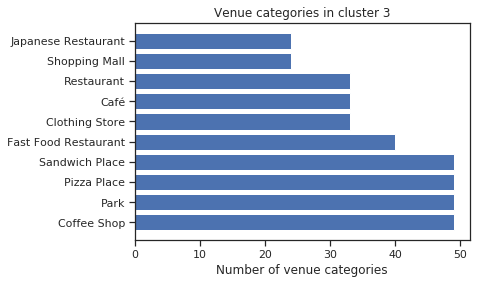

In [75]:
#count venue categories in all neighborhoods in the cluster
t3 = total_venue_categories(merged[merged['Cluster Labels'] == 3])

y_pos = np.arange(len(t3['Venue Category']))
plt.barh(y_pos, t3['Venue Count'], align='center')
plt.yticks(y_pos, t3['Venue Category'])
plt.xlabel('Number of venue categories')
plt.title('Venue categories in cluster 3')
 
plt.show()

## Fifth cluster - Cluster 4

In [76]:
merged.loc[merged['Cluster Labels'] == 4, merged.columns[[1] + list(range(5, merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Rouge,Malvern",Chinese Restaurant,Breakfast Spot,Bakery,Fast Food Restaurant,Coffee Shop,Pizza Place,Thai Restaurant,Bank,Fried Chicken Joint,Pharmacy
1,"Port Union,Rouge Hill,Highland Creek",Chinese Restaurant,Breakfast Spot,Bakery,Fast Food Restaurant,Coffee Shop,Pizza Place,Thai Restaurant,Bank,Fried Chicken Joint,Pharmacy
2,"Guildwood,Morningside,West Hill",Chinese Restaurant,Breakfast Spot,Bakery,Fast Food Restaurant,Coffee Shop,Pizza Place,Thai Restaurant,Bank,Fried Chicken Joint,Pharmacy
3,Woburn,Chinese Restaurant,Breakfast Spot,Bakery,Fast Food Restaurant,Coffee Shop,Pizza Place,Thai Restaurant,Bank,Fried Chicken Joint,Pharmacy
4,Cedarbrae,Chinese Restaurant,Breakfast Spot,Bakery,Fast Food Restaurant,Coffee Shop,Pizza Place,Thai Restaurant,Bank,Fried Chicken Joint,Pharmacy
5,Scarborough Village,Chinese Restaurant,Breakfast Spot,Bakery,Fast Food Restaurant,Coffee Shop,Pizza Place,Thai Restaurant,Bank,Fried Chicken Joint,Pharmacy
6,"East Birchmount Park,Ionview,Kennedy Park",Chinese Restaurant,Breakfast Spot,Bakery,Fast Food Restaurant,Coffee Shop,Pizza Place,Thai Restaurant,Bank,Fried Chicken Joint,Pharmacy
7,"Golden Mile,Oakridge,Clairlea",Chinese Restaurant,Breakfast Spot,Bakery,Fast Food Restaurant,Coffee Shop,Pizza Place,Thai Restaurant,Bank,Fried Chicken Joint,Pharmacy
8,"Cliffcrest,Scarborough Village West,Cliffside",Chinese Restaurant,Breakfast Spot,Bakery,Fast Food Restaurant,Coffee Shop,Pizza Place,Thai Restaurant,Bank,Fried Chicken Joint,Pharmacy
9,"Cliffside West,Birch Cliff",Chinese Restaurant,Breakfast Spot,Bakery,Fast Food Restaurant,Coffee Shop,Pizza Place,Thai Restaurant,Bank,Fried Chicken Joint,Pharmacy


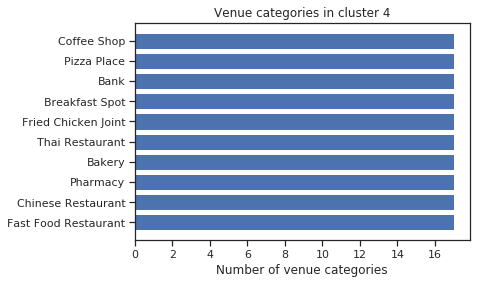

In [77]:
#count venue categories in all neighborhoods in the cluster
t4 = total_venue_categories(merged[merged['Cluster Labels'] == 4])

y_pos = np.arange(len(t4['Venue Category']))
plt.barh(y_pos, t4['Venue Count'], align='center')
plt.yticks(y_pos, t4['Venue Category'])
plt.xlabel('Number of venue categories')
plt.title('Venue categories in cluster 4')
 
plt.show()

In [78]:
# create map of a typical Toronto Neighborhood
toronto_map = folium.Map(location=[latitude, longitude], zoom_start=18)

toronto_map

<BarContainer object of 78 artists>

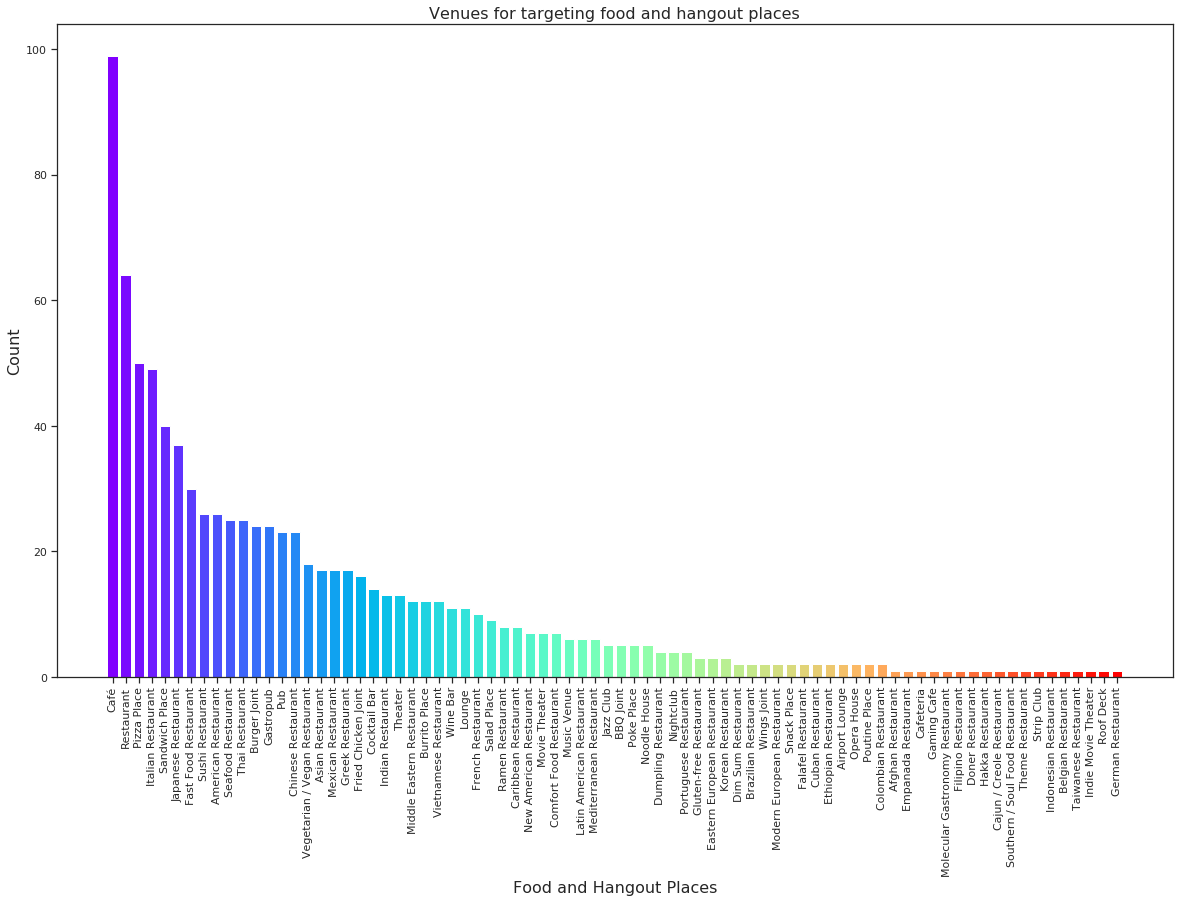

In [79]:
venue_distribution_res = Places_food['Venue Category'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution_res.index)))
plt.figure(figsize = (20, 12))
plt.xticks(rotation = 90)
plt.xlabel("Food and Hangout Places", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Venues for targeting food and hangout places", fontsize = 16)
plt.bar(venue_distribution_res.index, venue_distribution_res.values, color = colors)

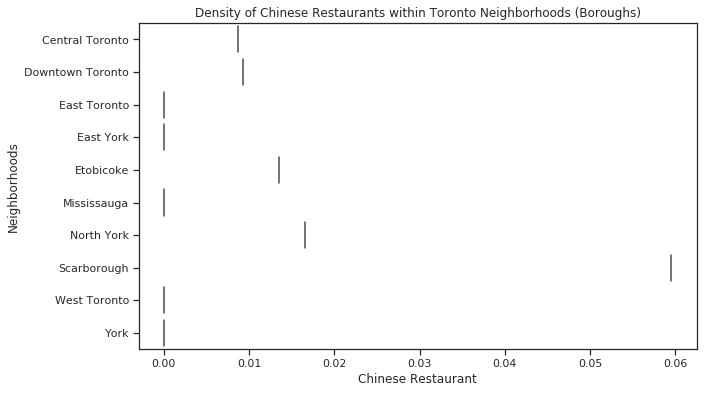

In [84]:
fig, ax = pyplot.subplots(figsize =(10, 6)) 
ax = sns.violinplot(x="Chinese Restaurant", y="Neighborhoods", data=to_chinese)
plt.title("Density of Chinese Restaurants within Toronto Neighborhoods (Boroughs)")

plt.show()

# Results and Discussion <a name="results"></a>

In trying to find best possible location(s) for Chinese restaurant within Toronto neighbourhoods, to assist a businessperson who is interested in opening a Chinese restaurant in Toronto, Ontario, 11 boroughs, 103 neighborhoods and 2213 venues were identified. The boroughs were Central Toronto, Downtown Toronto, East Toronto, East York, Etobicoke, Mississauga, North York, Queen's Park, Scarborough, West toronto and York. Apart from Queen's Park, 266 unique venue cotegories were identified in other 10 boroughs. Chinese restaurant was predicted to exist in 5 boroughs: Central Toronto, Downtown Toronto, Etibicoke, North York and Scarborough.

Analysis shows that similarities in venue category occur in 5 clusters across neighborhoods in Toronto. The first cluster - Cluster 0 (red) exists amongst the lone neighborhood in Mississauga with 10 most common venues more of food places,with very limited or no Chinese restaurant. The second cluster - Cluster 1 exists in York which has 5 neighborhoods with 10 most common venues (diverse), present in all 5 neighborhoods. Analysis shows shat there is very limited on no Chinese restaurant in Cluster 1.

The third cluster - Cluster 2 exists in Downtown Toronto, East Toronto and West Toronto. They have a total of 30 neighborhoods with 10 most common venues more of food places. Café, restaurant, coffee shop, Italian restaurant and bakery found in all 30 neighborhoods, while bar is found in about 24 neighborhoods, park in about 23, and hotel, Japanese restaurant and seafood restaurant in about 18 neighborhoods. Analysis shows that few Chinese restaurants actually exist in Downtown Toronto, and probably very limited or none in East Toronto and West Toronto.

The fourth cluster - Cluster 3 exists in Etibicoke, North York, Central Toronto and East York with a total of 54 neighborhoods. The 10 most common venues are more of food places. Sandwich place, pizza place,park and coffee shop are predicted to exist in about 48 neighborhoods. Fast food restaurant in about 38 neighborhoods, clothing store, Café, and restaurant in about 33 neighborhoods. Shopping mall and Japanese restaurant in about 24 neighborhoods. Analysis shows that there are a considerable number of Chinese restaurants in North York, few in Etibicoke, fewer in Central Toronto, and very limited or none in East York. 

The fifth cluster - Cluster 4 exists on Scarborough which has 17 neighborhoods with diverse 10 most common venues (including Chinese restaurant) in all 17 neighborhoods. Analysis shows that cluster 4 has the highest number of Chinese restaurants, perhaps due to high Chinese population in Scarborough.

Generally, analysis show that among 78 venues for targetting food and hangout places, chinese restaurant comes at postition 15. These Chinese restaurants are mainli in Scarborough, North York, Etibicoke, Downtown Toronto and Central Toronto. Neighborhoods in East York, East Toronto, Mississauga, West Toronto and York may likely be potential areas for a businessperson to open Chinese restaurant, as they probably have very limited number of or no Chinese restaurant at all. 

# Conclusion <a name="conclusion"></a>

Toronto is actually a city of neighborhoods. This aim of this project was to identify neighborhood(s) with less number of (or no) Chinese restaurant, to assist a businessperson who is willing to own a Chinese restaurant in Toronto. The businessperson will be at liberty to choose any neighborhood within the 5 boroughs with very limited number of (or no) Chinese restaurant for his Chinese restaurant business. 

Results of this work may be of interest to individuals who wish to patronise Chinese restaurant in Toronto. It can give a quick overview of neighborhoods with potential Chinese restaurants, for example, Scarborough and North York.

However, this study can be further improved with the help of more data and different machine learning techniques. For example, population data and heatmap of possible suitable locations can improve the study greatly. Nonetheless, the results of this study have demonstrated to be of immense use within the context of choosing neighborhoods with no Chinese restaurant for Chinese restaurant business.